# 🔺🔵🟩 Simple Shape Image Classification
---

Given *images of shapes*, let's try to **classify** them into the right category.

We will use TensorFlow/Keras CNN to make the predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
image_dir = Path('../input/basicshapes/shapes/shapes')

# Create File DataFrame

In [3]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split((os.path.split(x)[0]))[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images_df = pd.concat([filepaths, labels], axis=1)
train_df, test_df = train_test_split(images_df, train_size=0.7, shuffle=True, random_state=0)

# Loading Image Data

In [4]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation'
)

test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

Found 168 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.


# Visualization

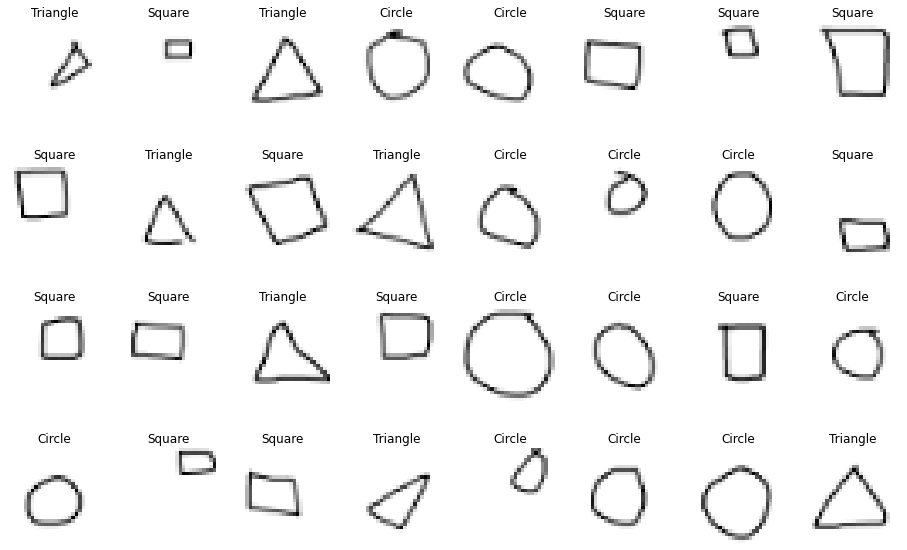

In [6]:
images = train_images[0][0]
labels = pd.Series(map(lambda x: x.argmax(), train_images[0][1][:])).map(
    {0: "Circle", 1: "Square", 2:"Triangle"})
    

plt.figure(figsize=(16, 10))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

The shapes are sometimes intentionally badly drawn which might decrease the accuracy.

# Training

In [7]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True)
    ]
)

2022-10-18 16:50:14.560117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 16:50:14.635659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 16:50:14.636425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 16:50:14.637543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100


2022-10-18 16:50:18.346061: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6/6 [==============================] - 7s 113ms/step - loss: 1.1015 - accuracy: 0.3512 - val_loss: 1.0984 - val_accuracy: 0.3333
Epoch 2/100
6/6 [==============================] - 0s 34ms/step - loss: 1.1000 - accuracy: 0.3512 - val_loss: 1.1007 - val_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - 0s 30ms/step - loss: 1.0983 - accuracy: 0.3512 - val_loss: 1.1006 - val_accuracy: 0.2857
Epoch 4/100
6/6 [==============================] - 0s 30ms/step - loss: 1.0999 - accuracy: 0.2798 - val_loss: 1.0962 - val_accuracy: 0.3333
Epoch 5/100
6/6 [==============================] - 0s 30ms/step - loss: 1.0944 - accuracy: 0.3512 - val_loss: 1.0951 - val_accuracy: 0.3333
Epoch 6/100
6/6 [==============================] - 0s 32ms/step - loss: 1.0940 - accuracy: 0.3512 - val_loss: 1.0910 - val_accuracy: 0.3333
Epoch 7/100
6/6 [==============================] - 0s 30ms/step - loss: 1.0937 - accuracy: 0.3512 - val_loss: 1.0912 - val_accuracy: 0.3333
Epoch 8/100
6/6 [==============

In [8]:
model.load_weights('./model.h5')

# Results

In [9]:
results = model.evaluate(test_images, verbose=0)
print("Loss: {:.4f}".format(results[0]))
print("Accuracy: {:.2f} %".format(results[1] * 100))

Loss: 0.4719
Accuracy: 77.78 %
